In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import pandas as pd
import numpy as np

In [52]:
file_path = '/content/drive/MyDrive/Kopis/국뮤/국뮤_2023_병합_4.xlsx'
mix_df_2 = pd.read_excel(file_path)

In [53]:
file_path = '/content/drive/MyDrive/Kopis/국악/국악_2023_병합_4.xlsx'
korean_df_2 = pd.read_excel(file_path)

In [54]:
file_path = '/content/drive/MyDrive/Kopis/뮤지컬/뮤지컬_2023_병합_4.xlsx'
musical_df_2 = pd.read_excel(file_path)

In [55]:
mix_df_2['장르명'] = '국악뮤지컬'
korean_df_2['장르명'] = '국악'
musical_df_2['장르명'] = '뮤지컬'

In [56]:
combined_df = pd.concat([mix_df_2, korean_df_2, musical_df_2], ignore_index=True)
combined_df = combined_df[combined_df['성별'] != 0]

## GMM

In [57]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 사용할 변수 선택
selected_columns = ['예매/취소구분', '할인금액', '성별',
                    '소요시간', '판매좌석수', '시설특성_코드',
                    '나이', '공연지역_구분', '분기',
                    '공연일수', '가격대', '수상실적횟수', '규모']

# 선택된 데이터를 추출
selected_df = combined_df[selected_columns]

# 범주형 변수를 숫자로 변환 (One-Hot Encoding)
selected_df = pd.get_dummies(selected_df, columns=['예매/취소구분', '성별', '시설특성_코드',
                                                       '공연지역_구분', '분기', '가격대', '규모'])

# 수치형 데이터에 대해 정규화 적용
scaler = StandardScaler()
data_selected_scaled = scaler.fit_transform(selected_df.dropna())

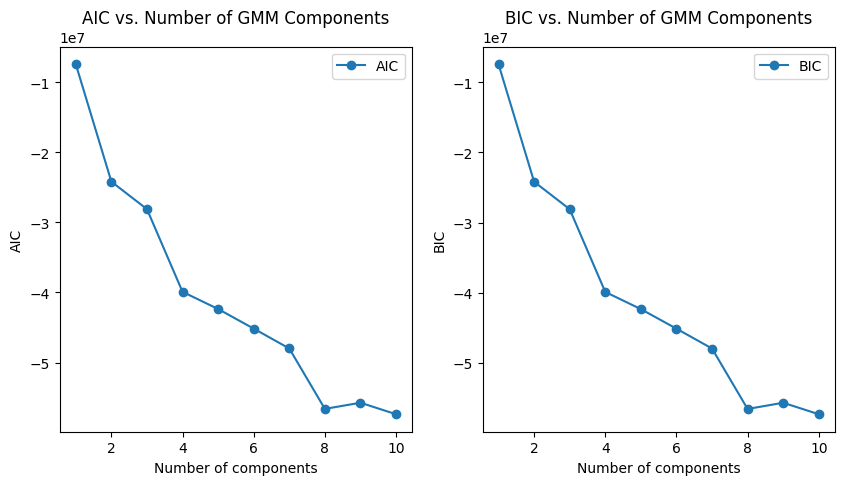

In [58]:
import matplotlib.pyplot as plt

# 클러스터 수에 따른 AIC와 BIC 값을 저장할 리스트
aic = []
bic = []

# 클러스터 수를 1부터 10까지 변화시키며 GMM을 적용
n_components_range = range(1, 11)
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(data_selected_scaled)

    # 각 클러스터 수에 대한 AIC와 BIC 값을 저장
    aic.append(gmm.aic(data_selected_scaled))
    bic.append(gmm.bic(data_selected_scaled))

# AIC와 BIC 그래프 그리기
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic, marker='o', label='AIC')
plt.xlabel('Number of components')
plt.ylabel('AIC')
plt.title('AIC vs. Number of GMM Components')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_components_range, bic, marker='o', label='BIC')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC vs. Number of GMM Components')
plt.legend()

plt.show()

In [59]:
# GMM 모델 초기화 및 학습
gmm4 = GaussianMixture(n_components=4, random_state=42)  # n_components는 클러스터의 수를 의미
gmm4.fit(data_selected_scaled)

# 클러스터 레이블 할당
cluster_labels4 = gmm4.predict(data_selected_scaled)

# 원본 데이터프레임에 클러스터 레이블 추가
selected_df['Cluster4'] = cluster_labels4

# 클러스터별 데이터 개수 확인
print(selected_df['Cluster4'].value_counts())


# GMM 모델 초기화 및 학습
gmm8 = GaussianMixture(n_components=8, random_state=42)  # n_components는 클러스터의 수를 의미
gmm8.fit(data_selected_scaled)

# 클러스터 레이블 할당
cluster_labels8 = gmm8.predict(data_selected_scaled)

# 원본 데이터프레임에 클러스터 레이블 추가
selected_df['Cluster8'] = cluster_labels8

# 클러스터별 데이터 개수 확인
print(selected_df['Cluster8'].value_counts())

Cluster4
2    139382
1    104342
0     85946
3     30753
Name: count, dtype: int64
Cluster8
3    84056
1    77261
4    70495
2    56784
0    28850
6    18754
5    15791
7     8432
Name: count, dtype: int64


## 군집화 후 장르명 다시 추가

In [60]:
# 'combined_df'의 '장르명' 열을 'selected_df'에 추가
selected_df['장르명'] = combined_df['장르명']

selected_df = pd.get_dummies(selected_df, columns=['장르명'])

selected_df['장르명'] = combined_df['장르명']
selected_df['예매/취소금액'] = combined_df['예매/취소금액']

##n=4

In [61]:
# 군집별 주요 수치형 변수의 통계 요약 (평균 및 표준편차)
cluster_summary = selected_df.groupby('Cluster4').agg({
    '할인금액': ['mean', 'std'],
    '소요시간': ['mean', 'std'],
    '판매좌석수': ['mean', 'std'],
    '나이': ['mean', 'std'],
    '공연일수': ['mean', 'std'],
    '수상실적횟수': ['mean', 'std']
}).reset_index()

# 군집별 주요 범주형 변수의 분포 요약
categorical_summary = selected_df.groupby('Cluster4').agg({
    '예매/취소구분_1': 'mean',
    '예매/취소구분_2': 'mean',
    '성별_1': 'mean',
    '성별_2': 'mean',
    '시설특성_코드_1': 'mean',
    '시설특성_코드_2': 'mean',
    '시설특성_코드_3': 'mean',
    '시설특성_코드_4': 'mean',
    '시설특성_코드_5': 'mean',
    '공연지역_구분_비수도권': 'mean',
    '공연지역_구분_수도권': 'mean',
    '분기_1': 'mean',
    '분기_2': 'mean',
    '분기_3': 'mean',
    '분기_4': 'mean',
    '규모_대극장': 'mean',
    '규모_중극장': 'mean',
    '규모_소극장': 'mean',
    '가격대_-5': 'mean',
    '가격대_10-15': 'mean',
    '가격대_15-': 'mean',
    '가격대_5-10': 'mean',
    '장르명_국악': 'mean',
    '장르명_국악뮤지컬': 'mean',
    '장르명_뮤지컬': 'mean'

}).reset_index()

cluster_summary, categorical_summary

(  Cluster4         할인금액                      소요시간                   판매좌석수  \
                    mean           std        mean        std         mean   
 0        0   253.905941   1507.444782   89.337828  29.068139   358.915424   
 1        1  7400.704894   8670.269906   83.733204  56.544838   644.999300   
 2        2  2878.549239   7507.553987  116.630842  26.032677   437.165308   
 3        3  3105.607583  10656.680619  141.814132  32.028893  2217.205834   
 
                        나이                  공연일수               수상실적횟수            
            std       mean        std       mean        std      mean       std  
 0   487.354512  42.640286  11.882347  19.805273  59.982322  0.000000  0.000000  
 1   450.811221  41.063311  13.134018   4.811083   7.585049  0.000000  0.000000  
 2   281.537583  32.788516  10.022907  74.041727  14.324030  0.087414  0.813663  
 3  4458.665135  37.673170  11.364620  48.196241  43.419992  0.899685  2.403033  ,
    Cluster4  예매/취소구분_1  예매/취소구분_2   

In [62]:
print(selected_df[selected_df['Cluster4'] == 0]['장르명'].value_counts())
print(selected_df[selected_df['Cluster4'] == 1]['장르명'].value_counts())
print(selected_df[selected_df['Cluster4'] == 2]['장르명'].value_counts())
print(selected_df[selected_df['Cluster4'] == 3]['장르명'].value_counts())

장르명
국악       77662
뮤지컬       7533
국악뮤지컬      751
Name: count, dtype: int64
장르명
국악       97149
국악뮤지컬     5228
뮤지컬       1965
Name: count, dtype: int64
장르명
국악뮤지컬    115720
뮤지컬       22257
국악         1405
Name: count, dtype: int64
장르명
뮤지컬      22276
국악        8401
국악뮤지컬       76
Name: count, dtype: int64


# **결론**

Cluster 0: **국악** 강세 +**비수도권** 강세 + 가격 매우 저렴 + 1군집보다 공연일수 긴 편 + 나이 평균 높음

Cluster 1: **국악** 강세 + **수도권** 100 + 가격 매우 저렴 + 나이 평균 높음 + 0군집보다 판매좌석 많음

Cluster 2: **국악뮤지컬** 강세 + **여성 매우 강세** + **수도권 100** + 2,3분기 강세(국악뮤지컬이 2,3분기에만 있어서) + 중극장 강세 + 가격 10 이하 대부분 + 3군집(뮤지컬강세)보다도 **나이 평균 낮음**

Cluster 3: **뮤지컬** 강세 + 수도권 강세 + 대극장 강세 + 가격 10 이상 대부분

In [80]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
selected_df['성별'] = combined_df['성별']
selected_df['나이_jittered'] = selected_df['나이'] + np.random.normal(0, 0.1, size=len(selected_df))
selected_df['성별_jittered'] = selected_df['성별'] + np.random.normal(0, 0.1, size=len(selected_df))
selected_df['예매/취소금액_jittered'] = selected_df['예매/취소금액'] + np.random.normal(0, 0.1, size=len(selected_df))

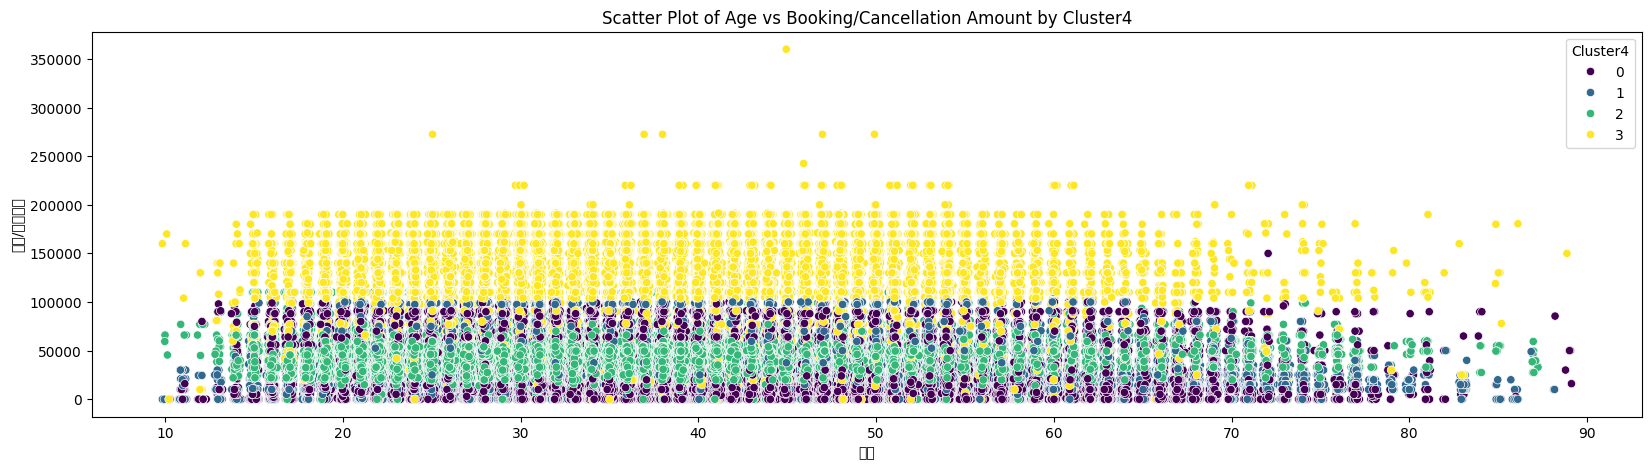

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

# Scatter plot
sns.scatterplot(data=selected_df, x='나이_jittered', y='예매/취소금액', hue='Cluster4', palette='viridis')

# 그래프 제목과 축 라벨 설정
plt.title('Scatter Plot of Age vs Booking/Cancellation Amount by Cluster4')
plt.xlabel('나이')
plt.ylabel('예매/취소금액')

# 그래프 출력
plt.show()

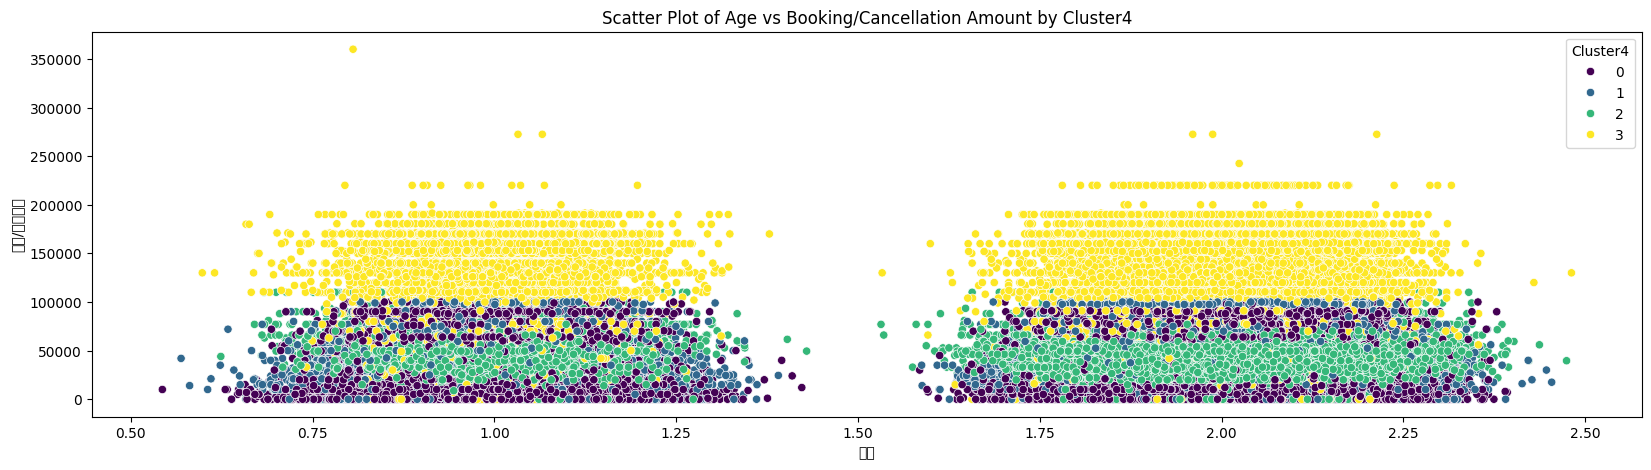

In [82]:
plt.figure(figsize=(20, 5))

# Scatter plot
sns.scatterplot(data=selected_df, x='성별_jittered', y='예매/취소금액', hue='Cluster4', palette='viridis')

# 그래프 제목과 축 라벨 설정
plt.title('Scatter Plot of Age vs Booking/Cancellation Amount by Cluster4')
plt.xlabel('성별')
plt.ylabel('예매/취소금액')

# 그래프 출력
plt.show()

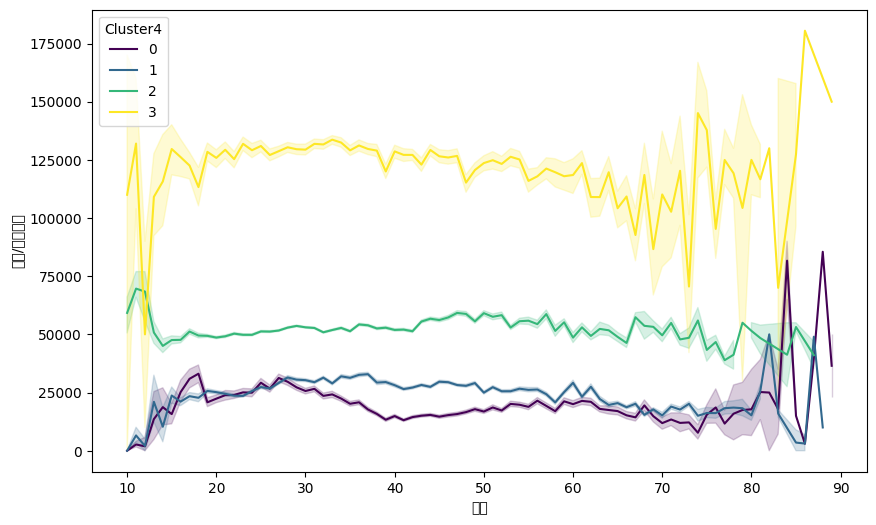

In [83]:
# 클러스터 분포 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=selected_df, x='나이', y='예매/취소금액', hue='Cluster4', palette='viridis')
plt.xlabel('나이')
plt.ylabel('예매/취소금액')
plt.legend(title='Cluster4')
plt.show()

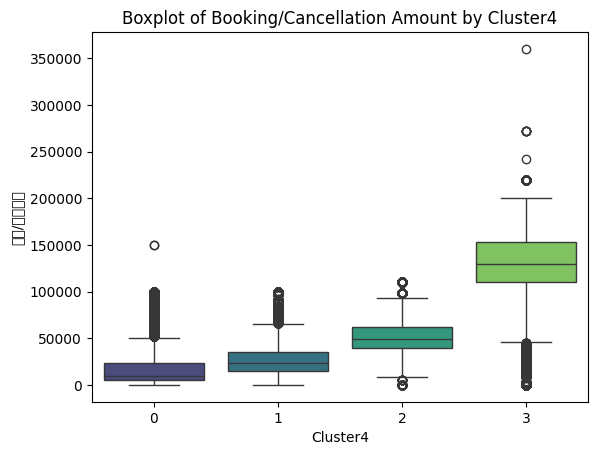

In [84]:
# 박스플롯 생성
sns.boxplot(data=selected_df, x='Cluster4', y='예매/취소금액', palette='viridis')

# 그래프 제목과 축 라벨 설정
plt.title('Boxplot of Booking/Cancellation Amount by Cluster4')
plt.xlabel('Cluster4')
plt.ylabel('예매/취소금액')

# 그래프 출력
plt.show()

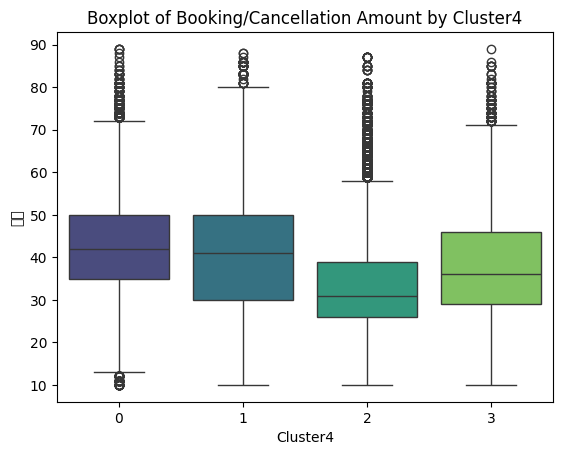

In [85]:
# 박스플롯 생성
sns.boxplot(data=selected_df, x='Cluster4', y='나이', palette='viridis')

# 그래프 제목과 축 라벨 설정
plt.title('Boxplot of Booking/Cancellation Amount by Cluster4')
plt.xlabel('Cluster4')
plt.ylabel('나이')

# 그래프 출력
plt.show()

##n=8

In [63]:
# 군집별 주요 수치형 변수의 통계 요약 (평균 및 표준편차)
cluster_summary = selected_df.groupby('Cluster8').agg({
    '할인금액': ['mean', 'std'],
    '소요시간': ['mean', 'std'],
    '판매좌석수': ['mean', 'std'],
    '나이': ['mean', 'std'],
    '공연일수': ['mean', 'std'],
    '수상실적횟수': ['mean', 'std']
}).reset_index()

# 군집별 주요 범주형 변수의 분포 요약
categorical_summary = selected_df.groupby('Cluster8').agg({
    '예매/취소구분_1': 'mean',
    '예매/취소구분_2': 'mean',
    '성별_1': 'mean',
    '성별_2': 'mean',
    '시설특성_코드_1': 'mean',
    '시설특성_코드_2': 'mean',
    '시설특성_코드_3': 'mean',
    '시설특성_코드_4': 'mean',
    '시설특성_코드_5': 'mean',
    '공연지역_구분_비수도권': 'mean',
    '공연지역_구분_수도권': 'mean',
    '분기_1': 'mean',
    '분기_2': 'mean',
    '분기_3': 'mean',
    '분기_4': 'mean',
    '규모_대극장': 'mean',
    '규모_중극장': 'mean',
    '규모_소극장': 'mean',
    '가격대_-5': 'mean',
    '가격대_10-15': 'mean',
    '가격대_15-': 'mean',
    '가격대_5-10': 'mean',
    '장르명_국악': 'mean',
    '장르명_국악뮤지컬': 'mean',
    '장르명_뮤지컬': 'mean'

}).reset_index()

cluster_summary, categorical_summary

(  Cluster8         할인금액                      소요시간                   판매좌석수  \
                    mean           std        mean        std         mean   
 0        0   232.474870   1572.726967   93.602149  33.758549   416.128319   
 1        1  4627.409042   9091.996581   99.854066  16.605657   321.140446   
 2        2   220.574458   1702.420723  140.659605  16.989603   623.241811   
 3        3  8971.945489   8839.443575   85.098327  59.104338   743.014264   
 4        4   278.388538   1479.819062   88.156564  32.756865   350.751358   
 5        5  2767.411817   7420.957072   85.924261  31.308477   217.868723   
 6        6  4960.779034  13238.514808  136.192279  35.106955  2455.405247   
 7        7   414.551708   2289.033239  160.282851  13.578627  2180.907495   
 
                        나이                  공연일수               수상실적횟수            
            std       mean        std       mean        std      mean       std  
 0   545.793889  44.569567  13.499621   8.807764  26.3

In [64]:
print(selected_df[selected_df['Cluster8'] == 0]['장르명'].value_counts())
print(selected_df[selected_df['Cluster8'] == 1]['장르명'].value_counts())
print(selected_df[selected_df['Cluster8'] == 2]['장르명'].value_counts())
print(selected_df[selected_df['Cluster8'] == 3]['장르명'].value_counts())
print(selected_df[selected_df['Cluster8'] == 4]['장르명'].value_counts())
print(selected_df[selected_df['Cluster8'] == 5]['장르명'].value_counts())
print(selected_df[selected_df['Cluster8'] == 6]['장르명'].value_counts())
print(selected_df[selected_df['Cluster8'] == 7]['장르명'].value_counts())

장르명
국악       25911
뮤지컬       2803
국악뮤지컬      136
Name: count, dtype: int64
장르명
국악뮤지컬    64090
뮤지컬      11075
국악        2096
Name: count, dtype: int64
장르명
국악뮤지컬    51629
뮤지컬       5155
Name: count, dtype: int64
장르명
국악       77566
국악뮤지컬     5228
뮤지컬       1262
Name: count, dtype: int64
장르명
국악       63113
뮤지컬       6767
국악뮤지컬      615
Name: count, dtype: int64
장르명
국악       9632
뮤지컬      6158
국악뮤지컬       1
Name: count, dtype: int64
장르명
뮤지컬      12503
국악        6175
국악뮤지컬       76
Name: count, dtype: int64
장르명
뮤지컬    8308
국악      124
Name: count, dtype: int64


# **결론**

Cluster 0: **국악** 강세 + 평균 나이 높음 + **남성 100** + 비수도권 강세 + 국악이지만 높은 가격의 공연 존재

Cluster 3: **국악** 강세 + 평균 나이 높음 + 할인금액 높음 + 여성 강세 + **수도권 100** + 대극장 강세

Cluster 4: **국악** 강세 + 평균 나이 높음 + **여성 100** + 비수도권 강세




Cluster 1: **국악뮤지컬** 강세 + 할인금액 높음 + **평균 나이 매우 낮음** + 여성 매우 강세 + **수도권 100** + **3분기** 강세 + **가격대 5이하** 100

Cluster 2: **국악뮤지컬** 강세 + 판매좌석 많음 + **평균 나이 매우 낮음** + 여성 강세 + **수도권 100** + **2분기** 강세 + **가격대 5-10** 강세 + 소요시간 김




Cluster 5: **국악 & 뮤지컬** 3:2 + 판매좌석 저조 + 남성16% + 수도권 강세 + **123분기** + **소극장** 강세 + **가격 저렴**

Cluster 6: **뮤지컬 & 국악** 2:1 + **할인금액 높음** + 판매좌석 많음 + 공연일수 짧은편 + 남성8% + 군집567 중 **비수도권** 높음 + 234분기 + 대극장 강세 + 가격 10-15 강세 & **15이상 없음**

Cluster 7: **뮤지컬** 강세 + 할인금액 낮음 + 소요시간 김 + **판매좌석 많음** + 평균 나이 낮은편 + **취소비율** 높음 + 남성20% + 34분기 + 대극장 강세 + **가격 15이상** 100





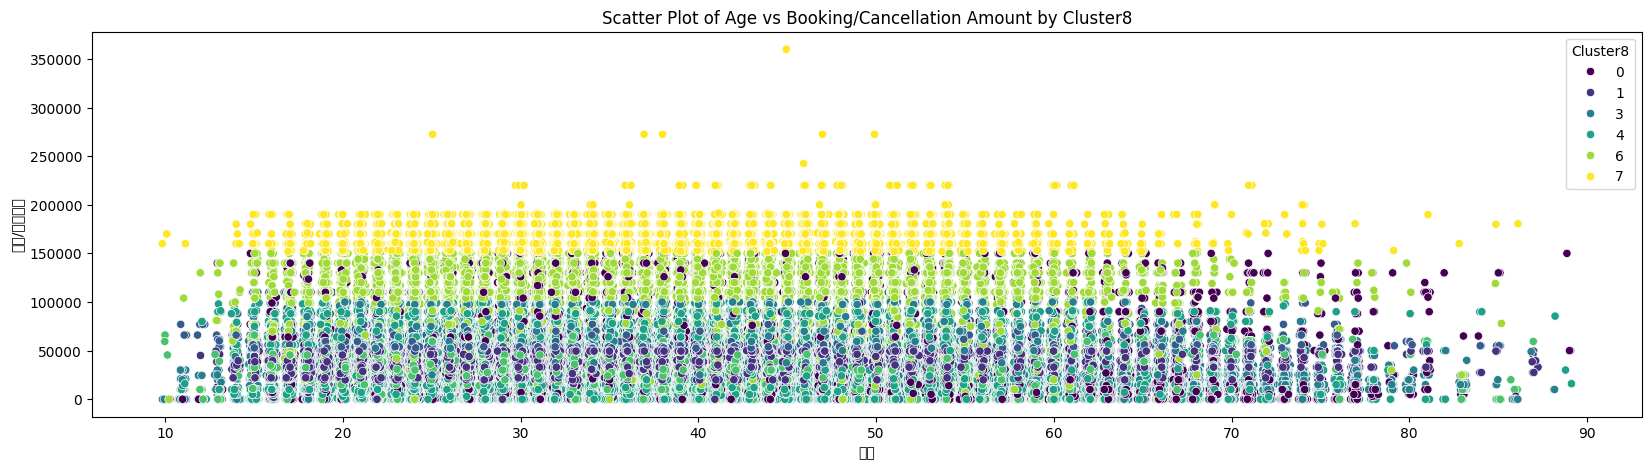

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

# Scatter plot
sns.scatterplot(data=selected_df, x='나이_jittered', y='예매/취소금액', hue='Cluster8', palette='viridis')

# 그래프 제목과 축 라벨 설정
plt.title('Scatter Plot of Age vs Booking/Cancellation Amount by Cluster8')
plt.xlabel('나이')
plt.ylabel('예매/취소금액')

# 그래프 출력
plt.show()

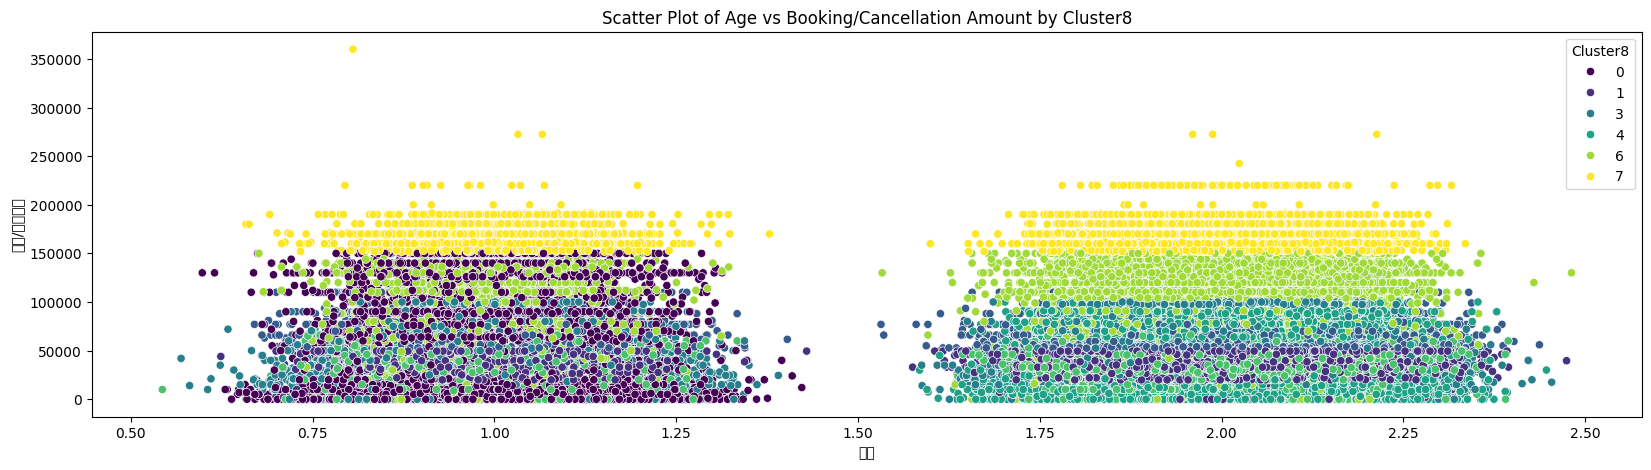

In [87]:
plt.figure(figsize=(20, 5))

# Scatter plot
sns.scatterplot(data=selected_df, x='성별_jittered', y='예매/취소금액', hue='Cluster8', palette='viridis')

# 그래프 제목과 축 라벨 설정
plt.title('Scatter Plot of Age vs Booking/Cancellation Amount by Cluster8')
plt.xlabel('성별')
plt.ylabel('예매/취소금액')

# 그래프 출력
plt.show()

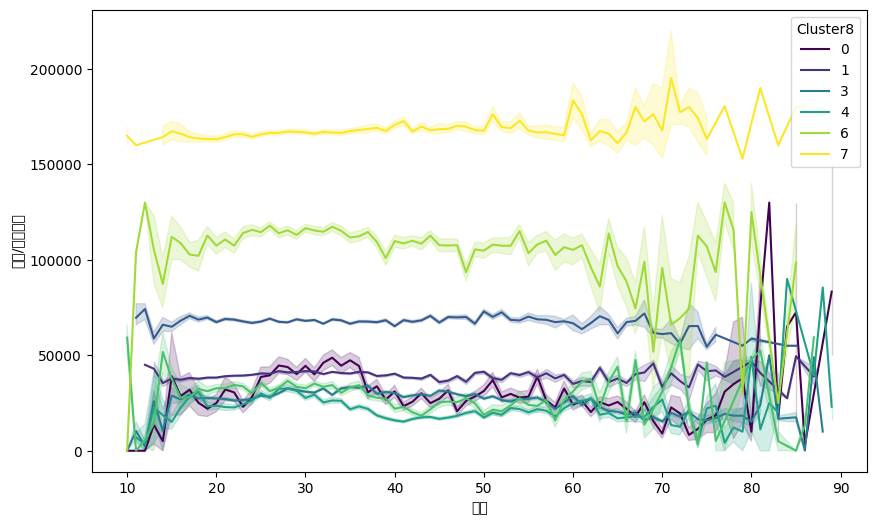

In [88]:
# 클러스터 분포 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=selected_df, x='나이', y='예매/취소금액', hue='Cluster8', palette='viridis')
plt.xlabel('나이')
plt.ylabel('예매/취소금액')
plt.legend(title='Cluster8')
plt.show()

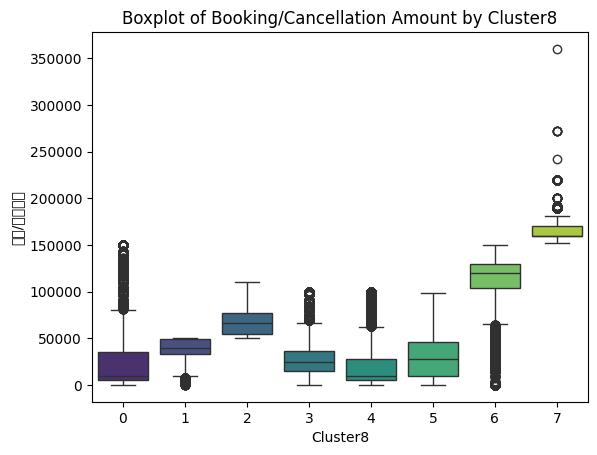

In [89]:
# 박스플롯 생성
sns.boxplot(data=selected_df, x='Cluster8', y='예매/취소금액', palette='viridis')

# 그래프 제목과 축 라벨 설정
plt.title('Boxplot of Booking/Cancellation Amount by Cluster8')
plt.xlabel('Cluster8')
plt.ylabel('예매/취소금액')

# 그래프 출력
plt.show()

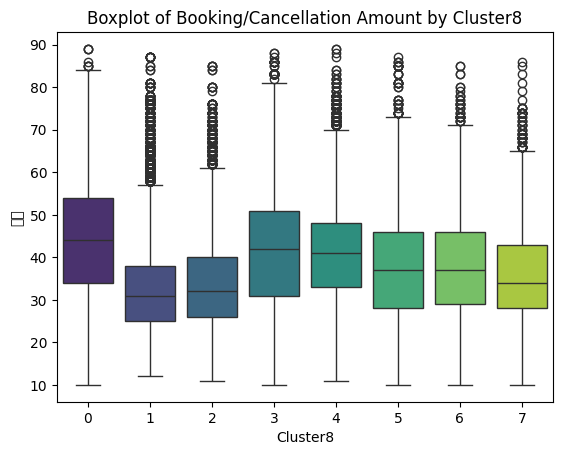

In [90]:
# 박스플롯 생성
sns.boxplot(data=selected_df, x='Cluster8', y='나이', palette='viridis')

# 그래프 제목과 축 라벨 설정
plt.title('Boxplot of Booking/Cancellation Amount by Cluster8')
plt.xlabel('Cluster8')
plt.ylabel('나이')

# 그래프 출력
plt.show()